In [ ]:
import itertools
import math
import os

import gsd.hoomd
import hoomd
import numpy

In [22]:
N_particles = 108
rho = 0.8442
target_total_energy_per_particle = -2.1626
box_volume = N_particles/rho
L = box_volume**(1/3)


spacing = L / math.ceil(N_particles ** (1/3))

x = numpy.linspace(-L / 2, L / 2, math.ceil(N_particles ** (1/3)), endpoint=False)
position = list(itertools.product(x, repeat=3))
def calculate_pe_of_lattice(positions):
    """Calculate PE of the initial simple cubic lattice"""
    energy = 0.0
    for i in range(N_particles):
        for j in range(i + 1, N_particles):
            # Distance with periodic boundary conditions
            dr = numpy.array(positions[i]) - numpy.array(positions[j])
            dr = dr - L * numpy.round(dr / L)
            r = numpy.linalg.norm(dr)
            
            # LJ potential with truncation and shift at r_cut = 2.5
            if r <= 2.5:
                r6 = (1.0/r)**6
                r12 = r6 * r6
                u_lj = 4.0 * (r12 - r6)
                # Shift correction
                u_cut = 4.0 * ((1.0/2.5)**12 - (1.0/2.5)**6)
                energy += u_lj - u_cut
    return energy


In [23]:
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, L, 0, 0, 0]

In [24]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if (
        "version" not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=0.5
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    samples = 2000
    if "CI" in os.environ:
        samples = 100
    return IPython.display.Image(tracer.sample(scene, samples=samples)._repr_png_())

In [25]:
frame.particles.types = ["A"]

In [26]:
if os.path.exists("lattice.gsd"):
    os.remove("lattice.gsd")

# Now open and write to the file
with gsd.hoomd.open(name="lattice.gsd", mode="x") as f:
    f.append(frame)

In [27]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(filename="lattice.gsd")

In [28]:
# Create the integrator
integrator = hoomd.md.Integrator(dt=0.002)

# Set up the neighbor list
cell = hoomd.md.nlist.Cell(buffer=0.019)  

# Set up Lennard-Jones potential  
lj = hoomd.md.pair.LJ(nlist=cell, mode='shift')
lj.params[("A", "A")] = dict(epsilon=1, sigma=1)
lj.r_cut[("A", "A")] = 2.5  


# Add the force to the integrator
integrator.forces.append(lj)

# Create an NVE method (ConstantVolume with no thermostat)
nve = hoomd.md.methods.ConstantVolume(filter=hoomd.filter.All(), thermostat=None)

# Add the NVE method to the integrator
integrator.methods.append(nve)

# Assign the integrator to the simulation
simulation.operations.integrator = integrator


In [30]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)
simulation.operations.computes.append(thermodynamic_properties)

In [31]:
# currently the velocities are 0
snapshot = simulation.state.get_snapshot()
snapshot.particles.velocity[0:5]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [32]:
def set_exact_kinetic_energy():
    """Set velocities to achieve exact target total energy"""
    import numpy as np
    
    # Target total energy per particle
    target_total_energy_per_particle = -2.1626
    target_total_energy = target_total_energy_per_particle * N_particles
    
    # Get current positions to calculate PE manually
    snapshot = simulation.state.get_snapshot()
    positions = snapshot.particles.position
    box_length = snapshot.configuration.box[0]
    
    # Calculate initial potential energy manually
    def calculate_pe_manual(positions, box_length):
        """Calculate PE using the same LJ parameters as HOOMD"""
        energy = 0.0
        n = len(positions)
        
        for i in range(n):
            for j in range(i + 1, n):
                # Distance with periodic boundary conditions
                dr = positions[i] - positions[j]
                dr = dr - box_length * np.round(dr / box_length)
                r = np.linalg.norm(dr)
                
                # LJ potential with truncation and shift at r_cut = 2.5
                if r <= 2.5:
                    r6 = (1.0/r)**6
                    r12 = r6 * r6
                    u_lj = 4.0 * (r12 - r6)
                    # Shift correction
                    u_cut = 4.0 * ((1.0/2.5)**12 - (1.0/2.5)**6)
                    energy += u_lj - u_cut
        
        return energy
    
    current_pe = calculate_pe_manual(positions, box_length)
    
    # Calculate required kinetic energy
    required_ke = target_total_energy - current_pe
    
    print(f"DIRECT VELOCITY ASSIGNMENT:")
    print(f"Current PE (manual): {current_pe:.6f}")
    print(f"Current PE per particle: {current_pe/N_particles:.6f}")
    print(f"Target total: {target_total_energy:.6f}")
    print(f"Required KE: {required_ke:.6f}")
    print(f"Required KE per particle: {required_ke/N_particles:.6f}")
    
    # Generate random velocities
    np.random.seed(42)  # For reproducibility
    velocities = np.random.normal(0, 1, (N_particles, 3))
    
    # Remove center of mass momentum
    com_velocity = np.mean(velocities, axis=0)
    velocities -= com_velocity
    
    # Scale to achieve exact target KE
    # KE = (1/2) * m * Σ(v²), with m=1 in reduced units
    current_ke_velocities = 0.5 * np.sum(velocities**2)
    scaling_factor = np.sqrt(required_ke / current_ke_velocities)
    velocities *= scaling_factor
    
    # Verify
    final_ke = 0.5 * np.sum(velocities**2)
    final_total = current_pe + final_ke
    
    print(f"Achieved KE: {final_ke:.6f}")
    print(f"Achieved total: {final_total:.6f}")
    print(f"Achieved total per particle: {final_total/N_particles:.6f}")
    print(f"Target per particle: {target_total_energy_per_particle:.6f}")
    print(f"Difference: {(final_total/N_particles - target_total_energy_per_particle):.8f}")
    
    # Set velocities in snapshot
    snapshot.particles.velocity[:] = velocities
    simulation.state.set_snapshot(snapshot)
    
    return final_ke, final_total

# Execute the direct velocity assignment
achieved_ke, achieved_total = set_exact_kinetic_energy()

# Verify the assignment worked
snapshot = simulation.state.get_snapshot()
snapshot.particles.velocity[0:5]


DIRECT VELOCITY ASSIGNMENT:
Current PE (manual): -351.097276
Current PE per particle: -3.250901
Target total: -233.560800
Required KE: 117.536476
Required KE per particle: 1.088301
Achieved KE: 117.536476
Achieved total: -233.560800
Achieved total per particle: -2.162600
Target per particle: -2.162600
Difference: 0.00000000


array([[ 0.34413058,  0.03481955,  0.46688787],
       [ 1.25566834, -0.05034578, -0.31631874],
       [ 1.30556808,  0.8392298 , -0.52533723],
       [ 0.3848493 , -0.25397034, -0.52201137],
       [ 0.11786885, -1.54168762, -1.64037825]])

In [33]:
# First, set up the thermodynamic properties compute
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All()
)
simulation.operations.computes.append(thermodynamic_properties)

# Create a custom action class to log energy
class EnergyLogger(hoomd.custom.Action):
    def __init__(self, filename):
        super().__init__()
        # Create the log file with a header
        with open(filename, "w") as f:
            f.write("timestep kinetic_energy potential_energy total_energy\n")
        self.filename = filename
        
    def act(self, timestep):
        # Access the energy values directly from thermodynamic_properties
        ke = self.thermodynamic_properties.kinetic_energy
        pe = self.thermodynamic_properties.potential_energy
        total = ke + pe
        
        # Write to the log file
        with open(self.filename, "a") as f:
            f.write(f"{timestep} {ke} {pe} {total}\n")
    
    def attach(self, simulation):
        # Call the parent attach method to set self._state
        super().attach(simulation)
        # Get a reference to the thermodynamic properties
        self.thermodynamic_properties = None
        for compute in simulation.operations.computes:
            if isinstance(compute, hoomd.md.compute.ThermodynamicQuantities):
                self.thermodynamic_properties = compute
                break

# Create the energy logger
energy_logger = EnergyLogger(filename="energy_log.txt")

# Create a custom writer with the energy logger
energy_writer = hoomd.write.CustomWriter(
    action=energy_logger,
    trigger=hoomd.trigger.Periodic(period=1)  # Log every 100 timesteps
)

# Add the writer to the simulation
simulation.operations.writers.append(energy_writer)

In [34]:
#finally we run
simulation.run(600000)

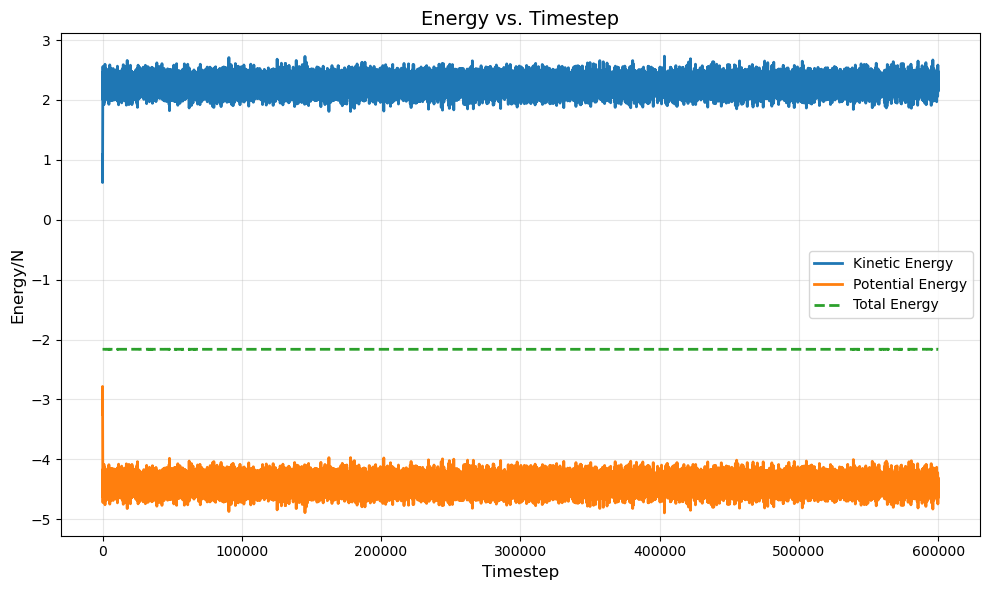

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the log file
data = np.loadtxt("energy_log.txt", skiprows=1)  # Skip the header row

# Extract columns
timesteps = data[:, 0]
kinetic_energy = data[:, 1]/N_particles
potential_energy = data[:, 2]/N_particles
total_energy = data[:, 3]/N_particles  # Already calculated in our logger

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the energies
plt.plot(timesteps, kinetic_energy, label='Kinetic Energy', linewidth=2)
plt.plot(timesteps, potential_energy, label='Potential Energy', linewidth=2)
plt.plot(timesteps, total_energy, label='Total Energy', linewidth=2, linestyle='--')

# Add labels and title
plt.xlabel('Timestep', fontsize=12)
plt.ylabel('Energy/N', fontsize=12)
plt.title('Energy vs. Timestep', fontsize=14)

# Add a grid and legend
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Improve appearance
plt.tight_layout()

# Save the figure
plt.savefig('energy_plot.png', dpi=300)

# Show the plot
plt.show()

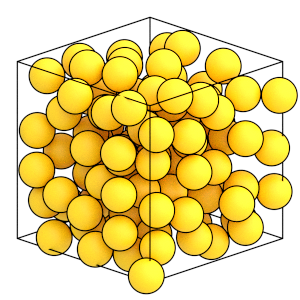

In [17]:
render(simulation.state.get_snapshot())

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def flyvbjerg_petersen_analysis(data, max_block_size=None):
    """
    Implement the Flyvbjerg-Petersen method for error analysis
    
    Parameters:
    data: array of measurements (e.g., potential energy values)
    max_block_size: maximum block size to consider
    
    Returns:
    block_sizes, standard_errors, num_blocks
    """
    
    data = np.array(data)
    n_data = len(data)
    
    # Set maximum block size if not provided
    if max_block_size is None:
        max_block_size = n_data // 4  # Don't go beyond n/4 for meaningful statistics
    
    block_sizes = []
    standard_errors = []
    num_blocks_list = []
    
    # Start with block size 1 and keep doubling
    block_size = 1
    while block_size <= max_block_size:
        # Calculate number of complete blocks
        num_blocks = n_data // block_size
        
        if num_blocks < 2:  # Need at least 2 blocks for variance
            break
            
        # Reshape data into blocks and calculate block averages
        truncated_data = data[:num_blocks * block_size]
        blocks = truncated_data.reshape(num_blocks, block_size)
        block_averages = np.mean(blocks, axis=1)
        
        # Calculate standard error of the block averages
        block_mean = np.mean(block_averages)
        block_variance = np.var(block_averages, ddof=1)  # Sample variance
        standard_error = np.sqrt(block_variance / num_blocks)
        
        block_sizes.append(block_size)
        standard_errors.append(standard_error)
        num_blocks_list.append(num_blocks)
        
        # Double the block size for next iteration
        block_size *= 2
    
    return np.array(block_sizes), np.array(standard_errors), np.array(num_blocks_list)

def plot_flyvbjerg_petersen(block_sizes, standard_errors, num_blocks, quantity_name="Observable"):
    """Plot the Flyvbjerg-Petersen analysis results"""
    
    plt.figure(figsize=(12, 5))
    
    # Plot standard error vs number of blocking operations
    plt.subplot(1, 2, 1)
    # Number of blocking operations M is log2(block_size)
    M = np.log2(block_sizes).astype(int)
    plt.plot(M, standard_errors, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Number of blocking operations (M)')
    plt.ylabel('Standard Error')
    plt.title(f'Flyvbjerg-Petersen Analysis\n{quantity_name}')
    plt.grid(True, alpha=0.3)
    
    # Add text showing the plateau value
    if len(standard_errors) > 3:
        plateau_error = standard_errors[-1]  # Take last value as plateau estimate
        plt.axhline(y=plateau_error, color='red', linestyle='--', alpha=0.7)
        plt.text(0.02, 0.98, f'Plateau: {plateau_error:.6f}', 
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Plot standard error vs block size
    plt.subplot(1, 2, 2)
    plt.loglog(block_sizes, standard_errors, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Block Size')
    plt.ylabel('Standard Error')
    plt.title('Standard Error vs Block Size')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [37]:
data = np.loadtxt("energy_log.txt", skiprows=1)
timesteps = data[:, 0]
kinetic_energy = data[:, 1] / N_particles
potential_energy = data[:, 2] / N_particles
total_energy = data[:, 3] / N_particles

print(f"Loaded {len(timesteps)} timesteps from energy_log.txt")
print(f"Energy data shape: {data.shape}")

Loaded 600000 timesteps from energy_log.txt
Energy data shape: (600000, 4)


In [38]:
equilibration_steps = 1000

# Remove equilibration period
equilibrated_mask = timesteps >= equilibration_steps
equilibrated_pe = potential_energy[equilibrated_mask]
equilibrated_ke = kinetic_energy[equilibrated_mask]
equilibrated_te = total_energy[equilibrated_mask]

print(f"Using {len(equilibrated_pe)} points after equilibration (t >= {equilibration_steps})")
print(f"Mean potential energy: {np.mean(equilibrated_pe):.6f}")
print(f"Mean kinetic energy: {np.mean(equilibrated_ke):.6f}")
print(f"Mean total energy: {np.mean(equilibrated_te):.6f}")

Using 599001 points after equilibration (t >= 1000)
Mean potential energy: -4.418980
Mean kinetic energy: 2.256272
Mean total energy: -2.162708


FLYVBJERG-PETERSEN ANALYSIS - POTENTIAL ENERGY

Detailed Results:
M (blocking ops) | Block Size | Standard Error | Number of Blocks
-----------------------------------------------------------------
              0 |          1 |      0.000141 |       599001
              1 |          2 |      0.000199 |       299500
              2 |          4 |      0.000280 |       149750
              3 |          8 |      0.000389 |        74875
              4 |         16 |      0.000518 |        37437
              5 |         32 |      0.000623 |        18718
              6 |         64 |      0.000675 |         9359
              7 |        128 |      0.000711 |         4679
              8 |        256 |      0.000746 |         2339
              9 |        512 |      0.000764 |         1169
             10 |       1024 |      0.000764 |          584
             11 |       2048 |      0.000792 |          292
             12 |       4096 |      0.000793 |          146
             13 |     

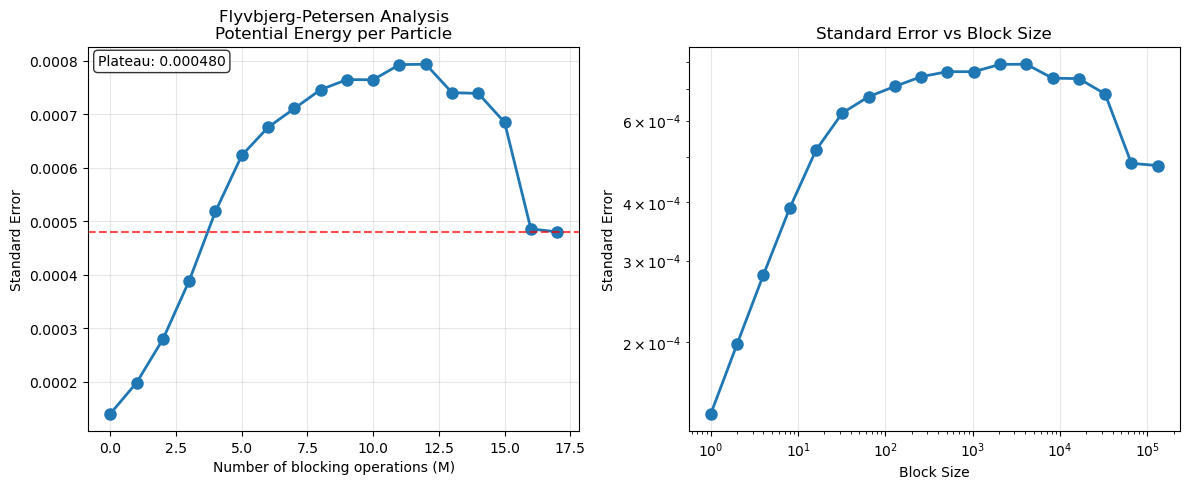

In [39]:
print("=" * 60)
print("FLYVBJERG-PETERSEN ANALYSIS - POTENTIAL ENERGY")
print("=" * 60)

# Perform the analysis
block_sizes_pe, std_errors_pe, num_blocks_pe = flyvbjerg_petersen_analysis(equilibrated_pe)

# Display detailed results
print("\nDetailed Results:")
print("M (blocking ops) | Block Size | Standard Error | Number of Blocks")
print("-" * 65)

for i, (bs, se, nb) in enumerate(zip(block_sizes_pe, std_errors_pe, num_blocks_pe)):
    M = int(np.log2(bs))
    print(f"{M:15d} | {bs:10d} | {se:13.6f} | {nb:12d}")

# Estimate final uncertainty (plateau value)
if len(std_errors_pe) >= 3:
    final_uncertainty_pe = std_errors_pe[-1]
    mean_pe = np.mean(equilibrated_pe)
    print(f"\nFinal Result for Potential Energy:")
    print(f"U/N = {mean_pe:.6f} ± {final_uncertainty_pe:.6f}")
else:
    print("Not enough blocking levels for reliable uncertainty estimate")

# Plot the results
plot_flyvbjerg_petersen(block_sizes_pe, std_errors_pe, num_blocks_pe, "Potential Energy per Particle")


FLYVBJERG-PETERSEN ANALYSIS - KINETIC ENERGY
M (blocking ops) | Block Size | Standard Error | Number of Blocks
-----------------------------------------------------------------
              0 |          1 |      0.000349 |        99001
              1 |          2 |      0.000493 |        49500
              2 |          4 |      0.000694 |        24750
              3 |          8 |      0.000966 |        12375
              4 |         16 |      0.001291 |         6187
              5 |         32 |      0.001548 |         3093
              6 |         64 |      0.001683 |         1546
              7 |        128 |      0.001789 |          773
              8 |        256 |      0.001924 |          386
              9 |        512 |      0.001950 |          193
             10 |       1024 |      0.001996 |           96
             11 |       2048 |      0.001940 |           48
             12 |       4096 |      0.001809 |           24
             13 |       8192 |      0.00183

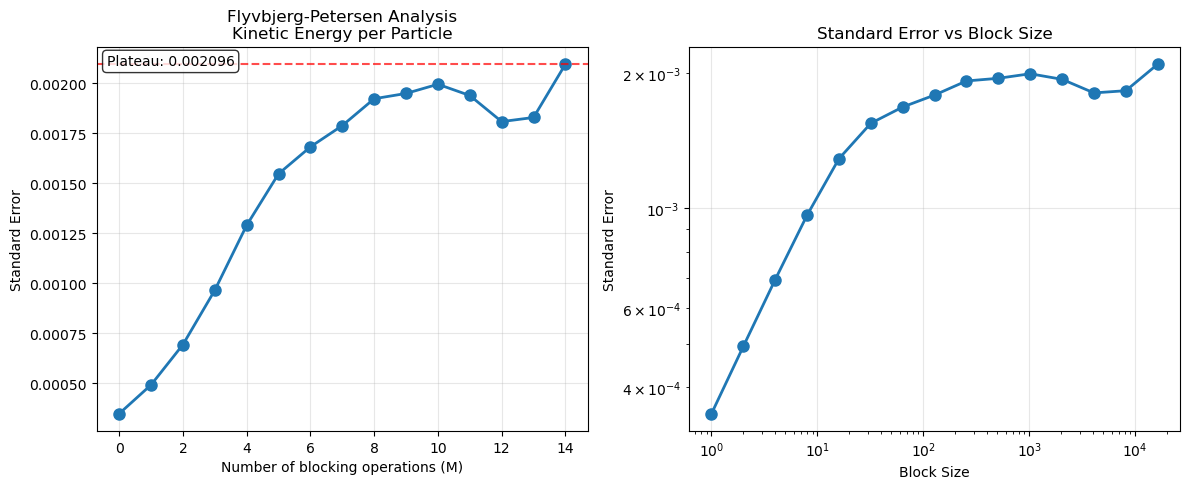

In [148]:
print("=" * 60)
print("FLYVBJERG-PETERSEN ANALYSIS - KINETIC ENERGY")
print("=" * 60)

# Perform the analysis
block_sizes_ke, std_errors_ke, num_blocks_ke = flyvbjerg_petersen_analysis(equilibrated_ke)

# Display results
print("M (blocking ops) | Block Size | Standard Error | Number of Blocks")
print("-" * 65)

for i, (bs, se, nb) in enumerate(zip(block_sizes_ke, std_errors_ke, num_blocks_ke)):
    M = int(np.log2(bs))
    print(f"{M:15d} | {bs:10d} | {se:13.6f} | {nb:12d}")

# Final results
if len(std_errors_ke) >= 3:
    final_uncertainty_ke = std_errors_ke[-1]
    mean_ke = np.mean(equilibrated_ke)
    # Convert kinetic energy to temperature (3/2 * kT = KE for 3D)
    # For LJ units: T = (2/3) * KE_per_particle
    temperature = (2.0/3.0) * mean_ke
    temp_uncertainty = (2.0/3.0) * final_uncertainty_ke
    
    print(f"\nFinal Results for Kinetic Energy:")
    print(f"K/N = {mean_ke:.6f} ± {final_uncertainty_ke:.6f}")
    print(f"Temperature = {temperature:.6f} ± {temp_uncertainty:.6f}")

plot_flyvbjerg_petersen(block_sizes_ke, std_errors_ke, num_blocks_ke, "Kinetic Energy per Particle")

Calculating time-averaged RDF...
Taking 100 snapshots...
Processed 10/100 snapshots
Processed 20/100 snapshots
Processed 30/100 snapshots
Processed 40/100 snapshots
Processed 50/100 snapshots
Processed 60/100 snapshots
Processed 70/100 snapshots
Processed 80/100 snapshots
Processed 90/100 snapshots
Processed 100/100 snapshots


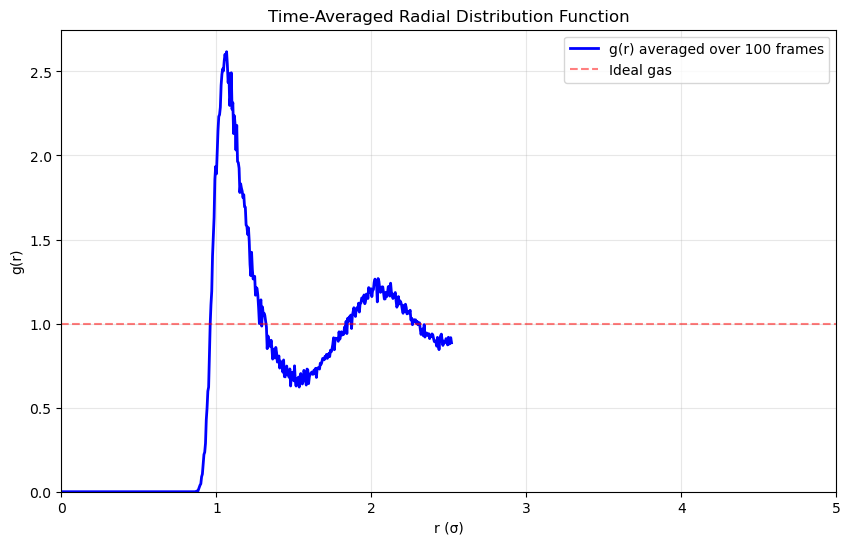

In [23]:
# Time-averaged RDF calculation
import numpy as np
import matplotlib.pyplot as plt

def calculate_rdf_frame(positions, box, nhis=500):
    """Calculate RDF for a single frame"""
    npart = len(positions)
    rho = npart / (box**3)
    delg = box / (2 * nhis)
    
    # Initialize histogram
    g = np.zeros(nhis)
    
    # Loop over all particle pairs
    for i in range(npart):
        for j in range(i + 1, npart):
            # Distance with periodic boundaries
            xr = positions[i] - positions[j]
            xr = xr - box * np.round(xr / box)
            r = np.sqrt(np.sum(xr**2))
            
            # Add to histogram if within range
            if r < box/2:
                ig = int(r / delg)
                if ig < nhis:
                    g[ig] += 2
    
    # Normalize to get g(r)
    r_values = np.zeros(nhis)
    g_final = np.zeros(nhis)
    
    for i in range(nhis):
        r_values[i] = delg * (i + 0.5)
        vb = ((i + 1)**3 - i**3) * (delg**3)
        nid = (4.0/3.0) * np.pi * vb * rho
        
        if nid > 0:
            g_final[i] = g[i] / (npart * nid)
    
    return r_values, g_final

# Method 1: Average over multiple snapshots from current simulation
print("Calculating time-averaged RDF...")

# Take snapshots every 1000 steps for the last part of simulation
n_snapshots = 100
snapshot_interval = 10000

# Initialize arrays for averaging
r_avg = None
g_avg = None
count = 0

print(f"Taking {n_snapshots} snapshots...")

# Run short simulation chunks and collect snapshots
for i in range(n_snapshots):
    # Run for snapshot_interval steps
    simulation.run(snapshot_interval)
    
    # Get current snapshot
    snapshot = simulation.state.get_snapshot()
    positions = snapshot.particles.position
    box = snapshot.configuration.box[0]
    
    # Calculate RDF for this frame
    r, g = calculate_rdf_frame(positions, box)
    
    # Add to average
    if r_avg is None:
        r_avg = r.copy()
        g_avg = g.copy()
    else:
        g_avg += g
    
    count += 1
    
    if (i+1) % 10 == 0:
        print(f"Processed {i+1}/{n_snapshots} snapshots")

# Finalize average
g_avg /= count

# Plot the time-averaged RDF
plt.figure(figsize=(10, 6))
plt.plot(r_avg, g_avg, 'b-', linewidth=2, label=f'g(r) averaged over {count} frames')
plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Ideal gas')
plt.xlabel('r (σ)')
plt.ylabel('g(r)')
plt.title('Time-Averaged Radial Distribution Function')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 5)
plt.ylim(0, None)
plt.show()


pressure tenser